In [1]:
import timm
import os
import cv2
import shutil
import random
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

c:\Users\20200333\.conda\envs\tf-gpu-3.10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# sdir = 'Plants_1'
# img_size = (224,224)

# working_dir = r'./'
# dstdir = os.path.join(working_dir, 'resized2')
# if os.path.isdir(dstdir):
#     shutil.rmtree(dstdir)
# os.mkdir(dstdir)

# filepaths = []
# labels = []
# plant_list = sorted(os.listdir(sdir))    
# for plant in plant_list:
#     plant_path = os.path.join(sdir, plant)
#     dst_plant_path = os.path.join(dstdir, plant)
#     os.mkdir(dst_plant_path)
#     classlist = sorted(os.listdir(plant_path))
    
#     for cl in classlist:
#         classpath = os.path.join(plant_path, cl)
#         dst_classpath = os.path.join(dst_plant_path, cl)
#         os.mkdir(dst_classpath)

#         # Only process if classpath is a directory
#         if os.path.isdir(classpath):  # Ensure classpath is a directory
#             flist = sorted(os.listdir(classpath))
#             desc = f'{plant:25s}-{cl:9s}'
            
#             for f in tqdm(flist, ncols=130, desc=desc, unit='files', colour='blue'):
#                 fpath = os.path.join(classpath, f)
#                 dst_fpath = os.path.join(dst_classpath, f)
                
#                 # Check if the file exists and is a valid image file
#                 if os.path.isfile(fpath):  # Ensure fpath is a file
#                     filepaths.append(dst_fpath)
#                     img = cv2.imread(fpath)
#                     img = cv2.resize(img, img_size)
#                     cv2.imwrite(dst_fpath, img)
#                     labels.append(plant + '-' + cl)

            
# Fseries = pd.Series(filepaths, name = 'filepaths')
# Lseries = pd.Series(labels, name = 'labels')
# df = pd.concat([Fseries, Lseries], axis = 1)

In [3]:
# df.to_csv('data.csv', index = False)

df = pd.read_csv('data.csv')
df['labels'] = df['labels'].apply(lambda x: x.split('-')[1])

In [4]:
# df_train, df_test = train_test_split(df, test_size = 0.2, stratify = df['labels'], random_state = 42, shuffle = True)
# df_train, df_val = train_test_split(df_train, test_size = 0.2, stratify = df_train['labels'], random_state = 42, shuffle = True)

df_train = df[df['filepaths'].str.contains('train')]
df_val = df[df['filepaths'].str.contains('val')]
df_test = df[df['filepaths'].str.contains('test')]

In [5]:
classes = sorted(df_train['labels'].unique())
class_count = len(classes)    
print('number of classes in processed dataset =', class_count)

counts = list(df_train['labels'].value_counts())
print('the maximum files in any class in df_train is ', max(counts), '  the minimum files in any class in df_train is ', min(counts))
print('df_train length: ', len(df_train), '  df_test length: ', len(df_test), '  df_val length: ', len(df_val))

# return df_train, df_test, df_val, classes, class_count
# df_train, df_test, df_val, classes, class_count = make_dataframes(sdir, img_size)

number of classes in processed dataset = 22
the maximum files in any class in df_train is  335   the minimum files in any class in df_train is  67
df_train length:  4274   df_test length:  110   df_val length:  110


In [6]:
class LeafDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        image = Image.open(img_name)
        label = self.data.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

def load_data(df):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                            [0.229, 0.224, 0.225])
    ])



    dataset = LeafDataset(df, transform=transform)
    return dataset

In [7]:
label_encoder = LabelEncoder()
label_encoder.fit(classes)
df_train['labels'] = label_encoder.transform(df_train['labels'])
df_test['labels'] = label_encoder.transform(df_test['labels'])
df_val['labels'] = label_encoder.transform(df_val['labels'])

train_dataset = load_data(df_train)
test_dataset = load_data(df_test)
val_dataset = load_data(df_val)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)
val_loader = DataLoader(val_dataset, batch_size=16)

C:\Users\20200333\AppData\Local\Temp\ipykernel_23748\2155821337.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['labels'] = label_encoder.transform(df_train['labels'])
C:\Users\20200333\AppData\Local\Temp\ipykernel_23748\2155821337.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['labels'] = label_encoder.transform(df_test['labels'])
C:\Users\20200333\AppData\Local\Temp\ipykernel_23748\2155821337.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [8]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.DEFAULT)
num_classes = len(label_encoder.classes_)
num_ftrs = base_model.classifier[0].in_features
base_model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, class_count),
    nn.LogSoftmax(dim=1)
)
# nn.Linear(num_ftrs, len(label_encoder.classes_))

base_model = base_model.to(device)

for param in base_model.parameters():
    param.requires_grad = False

for param in base_model.classifier.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(base_model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)







In [9]:
num_epochs = 64
patience = 8
counter = 0
best_val_loss = float('inf')

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    base_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = base_model(inputs)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    scheduler.step()

    base_model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = base_model(inputs)
            loss = criterion(outputs, labels.long())
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    val_loss_epoch = val_loss / len(val_loader)
    train_acc = (correct_train / total_train) * 100
    val_acc = (correct_val / total_val) * 100

    train_losses.append(train_loss)
    val_losses.append(val_loss_epoch)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss_epoch:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        counter = 0
        torch.save(base_model.state_dict(), 'mobilnet.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Unfreezing layers.")
            for name, param in base_model.named_parameters():
                if "layer4" in name or "classifier" in name:
                    param.requires_grad = True

            optimizer = optim.Adam(base_model.parameters(), lr=0.0001, weight_decay=1e-4) 
            continue




Epoch 1/64, Train Loss: 2.6234, Val Loss: 2.2913, Train Acc: 35.10%, Val Acc: 45.45%
Epoch 2/64, Train Loss: 1.7861, Val Loss: 1.6529, Train Acc: 66.96%, Val Acc: 67.27%
Epoch 3/64, Train Loss: 1.4132, Val Loss: 1.3882, Train Acc: 76.60%, Val Acc: 70.00%
Epoch 4/64, Train Loss: 1.3045, Val Loss: 1.3674, Train Acc: 80.46%, Val Acc: 71.82%
Epoch 5/64, Train Loss: 1.2728, Val Loss: 1.3553, Train Acc: 81.12%, Val Acc: 70.00%
Epoch 6/64, Train Loss: 1.2636, Val Loss: 1.3430, Train Acc: 81.19%, Val Acc: 70.00%
Epoch 7/64, Train Loss: 1.2582, Val Loss: 1.3393, Train Acc: 81.02%, Val Acc: 70.91%
Epoch 8/64, Train Loss: 1.2488, Val Loss: 1.3373, Train Acc: 82.59%, Val Acc: 70.91%
Epoch 9/64, Train Loss: 1.2594, Val Loss: 1.3418, Train Acc: 82.08%, Val Acc: 70.00%
Epoch 10/64, Train Loss: 1.2482, Val Loss: 1.3362, Train Acc: 82.45%, Val Acc: 69.09%
Epoch 11/64, Train Loss: 1.2558, Val Loss: 1.3402, Train Acc: 81.75%, Val Acc: 70.91%
Epoch 12/64, Train Loss: 1.2545, Val Loss: 1.3415, Train Acc: 8

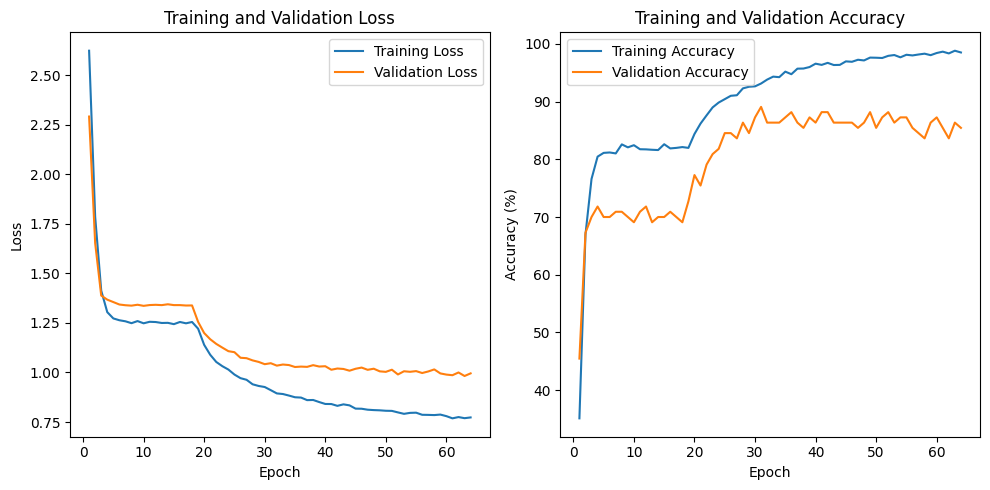

In [10]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(train_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_losses) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(train_losses) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()  
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return (correct / total) * 100

# Load model and test
base_model.load_state_dict(torch.load('mobilnet.pth'))
base_model.to(device)
test_accuracy = test_model(base_model, test_loader, device)
print(f"Test accuracy: {test_accuracy:.2f}%")



Test accuracy: 86.36%


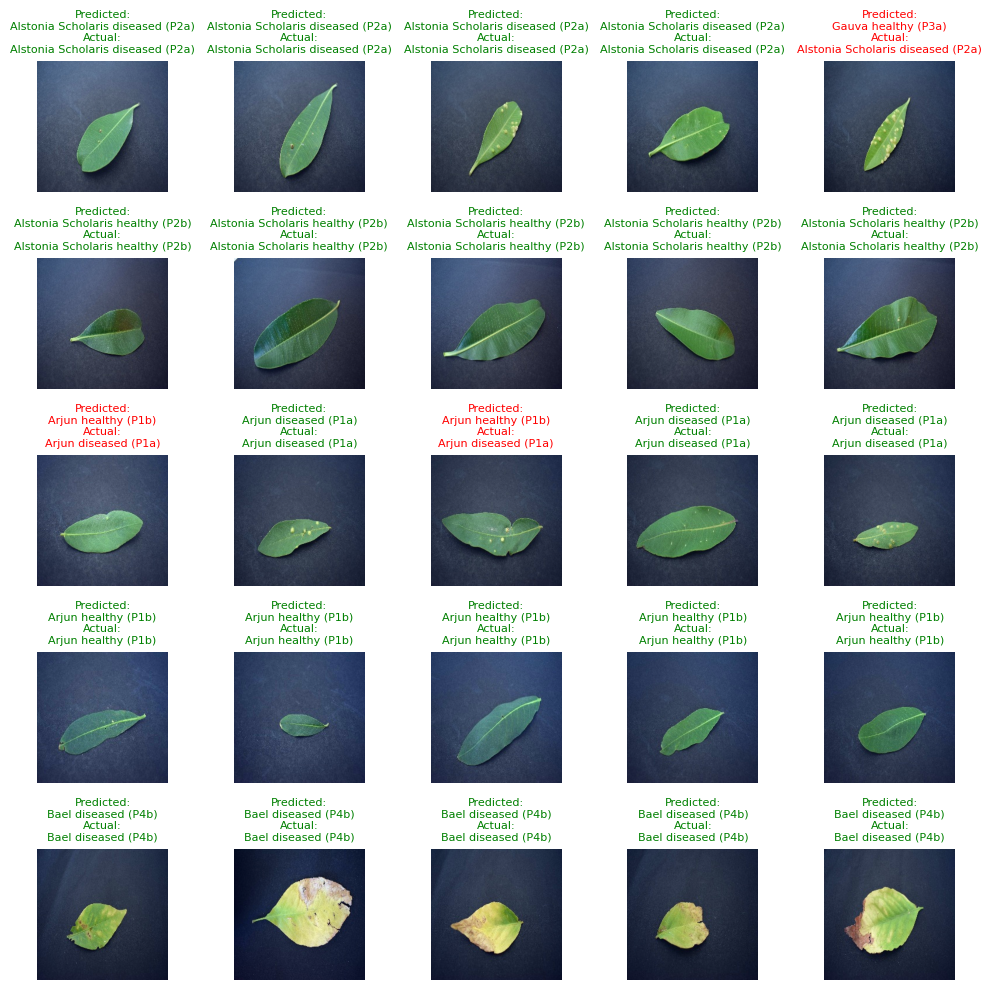

In [15]:
def predict_and_plot(model, test_loader, label_encoder, device):
    model.eval()
    model.to(device)
    images_so_far = 0
    fig, axs = plt.subplots(5, 5, figsize=(10, 10))

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            for i in range(inputs.size(0)):
                if images_so_far >= 25:
                    break
                ax = axs[images_so_far // 5, images_so_far % 5]
                ax.axis('off')
                pred_label = label_encoder.classes_[predicted[i].item()]
                true_label = label_encoder.classes_[labels[i].item()]
                color = 'green' if predicted[i] == labels[i] else 'red'
                ax.set_title(f'Predicted:\n{pred_label}\nActual:\n{true_label}', color=color, fontsize=8)

                img_np = inputs[i].detach().cpu().permute(1, 2, 0).numpy()
                img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
                ax.imshow(img_np)
                images_so_far += 1

            if images_so_far >= 25:
                break

    plt.tight_layout()
    plt.show()

predict_and_plot(base_model, test_loader, label_encoder, device)
